In [1]:
import sys
import os
#sys.path.insert(0, "/usr/src/app/app")
def import_path(fullpath):
    """ 
    Import a file with full path specification. Allows one to
    import from anywhere, something __import__ does not do. 
    """
    path, filename = os.path.split(fullpath)
    filename, ext = os.path.splitext(filename)
    sys.path.append(path)
    module = __import__(filename)
   # reload(module) # Might be out of date
    del sys.path[-1]
    return module
import_path("/usr/src/app/app")

<module 'app' from '/usr/src/app/app/__init__.py'>

In [2]:
from app.pkg.ml.try_on.preprocessing.aggregator import ClothProcessor
cp = ClothProcessor()

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [78]:
from app.pkg.ml.buffer_converters import BytesConverter
from PIL import Image
from app.pkg.models.app.image_category import ImageCategory
bc = BytesConverter()
outerwear_clothes_paths = ["/usr/src/app/data/upper/b_bloose.png", "/usr/src/app/data/upper/b_jacket.png"]
upper_clothes_paths = [ "/usr/src/app/data/upper/t-shirt-blue.png","/usr/src/app/data/upper/t-shirt-miami.png", "/usr/src/app/data/upper/b_t-shirt-2.png", "/usr/src/app/data/upper/b_t-shirt-3.png", "/usr/src/app/data/upper/t-shirt-dc.png", "/usr/src/app/data/upper/t-shirt-dc2.png", "/usr/src/app/data/upper/t-shirt.png" ]
lower_clothes_paths = ["/usr/src/app/data/lower/b_black_jeans.png", "/usr/src/app/data/lower/b_shorts.png", "/usr/src/app/data/lower/jeans-dc.png", "/usr/src/app/data/lower/shorts-dc.png" ]
dress_clothes_paths = ["/usr/src/app/data/dresses/1.png", "/usr/src/app/data/dresses/2.png", "/usr/src/app/data/dresses/dress-dc.png"]

user_images = ["/usr/src/app/data/human/brayan_krenston.png"]

def convert_cloth_to_dict(x, category=None):
    res = []
    for i in x:
        image = Image.open(i)
        im_no_back = cp.model_background(image)
        im_bytes = bc.image_to_bytes(im_no_back)
        res.append({'cloth':im_bytes, 'category':category})
    return res

def convert_user_to_dict(x):
    res = []
    for i in x:
        image = Image.open(i)
        im_no_back = cp.model_background(image)
        im_bytes = bc.image_to_bytes(im_no_back)
        res.append({'image':im_bytes})
    return res

#        im_white_back = cp.model_background.replace_background_RGBA(im_no_back)


upper_clothes = convert_cloth_to_dict(upper_clothes_paths, ImageCategory.UPPER_BODY)
lower_clothes = convert_cloth_to_dict(lower_clothes_paths, ImageCategory.LOWER_BODY)
dress_clothes = convert_cloth_to_dict(dress_clothes_paths, ImageCategory.DRESSES)
outerwear_clothes = convert_cloth_to_dict(outerwear_clothes_paths, ImageCategory.UPPER_BODY)
user_images = convert_user_to_dict(user_images)


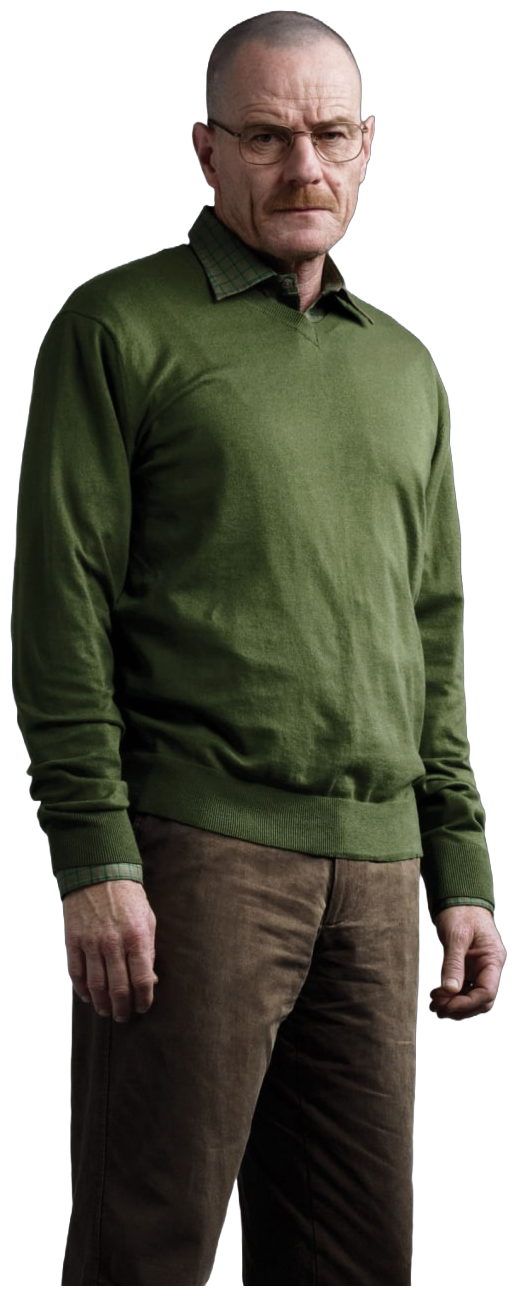

In [79]:
bc.bytes_to_image(user_images[0]['image'])

In [80]:
from typing import Dict, Union, List
import io

import torch
from transformers import AutoProcessor, CLIPModel, AutoTokenizer
from torch.nn import Softmax
from PIL import Image
import numpy as np

from app.pkg.ml.buffer_converters import BytesConverter
from app.pkg.ml.try_on.preprocessing.cloth import ClothPreprocessor

In [81]:
# class Cloth:
#     def __init__(self,
#                  uuid,
#                  bytes_array,
#                  ):
#         pass

In [110]:
class LocalRecSys:
    """
    Recommends set of clothes (outfit)
    """
    def __init__(self, device="cuda:0"):
        self.model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
        self.processor = AutoProcessor.from_pretrained("openai/clip-vit-base-patch32")
        self.tokenizer =  AutoTokenizer.from_pretrained("openai/clip-vit-base-patch32")
        self.device = device
        self.bytes_converter = BytesConverter()

    def forward(self,
                upper_clothes: List[Dict[str, io.BytesIO]] = [],
                lower_clothes: List[Dict[str, io.BytesIO]] = [],
                dresses_clothes: List[Dict[str, io.BytesIO]] = [],
                outerwear_clothes: List[Dict[str, io.BytesIO]] = [],
                
                # user_photos:List[Dict[str, io.BytesIO]],
                prompt: str = None,
                top_n: int = 10,
               ) -> Dict[str, Dict[str, float]]:
        """
        Gets probability for each tag
        
        Args:
            upper_clothes: List[Dict[str, io.BytesIO]],
            lower_clothes: List[Dict[str, io.BytesIO]],
            dresses_clothes: List[Dict[str, io.BytesIO]],
            # user_photos:List[Dict[str, io.BytesIO]] - photos of user to try_on in future.
            #         Recommends to use one or less images
            prompt: str = None - extra prompt to search
        Returns:
            dict with sets of clothes
        
        Return example:
        [
            {
            "score":1,
            "clothes":[,]
            },
            {
            "score":0.93,
            "clothes":[,]
            },
        ]
        """

        upper_clothes = self.get_embs_per_category(upper_clothes)
        lower_clothes = self.get_embs_per_category(lower_clothes)
        dresses_clothes = self.get_embs_per_category(dresses_clothes)
        outerwear_clothes = self.get_embs_per_category(outerwear_clothes)


        if prompt:
            prompt_features = self._get_text_embedding(prompt)

        # перебор все возможных комбинаций одежды
        outfits = []
        for up_cloth in upper_clothes:
            for low_cloth in lower_clothes:
                for outer_wear_cloth in [*outerwear_clothes, None]:
                    outfit = {'clothes':[up_cloth, low_cloth]}
                    if outer_wear_cloth is not None:
                      outfit['clothes'].append(outer_wear_cloth)  
                    self._evaluate_outfit(outfit=outfit,
                        prompt_features=prompt_features)
                    outfits.append(outfit)
                
        for dress in dresses_clothes:
         
                outfit = {'clothes':[dress]}
                self._evaluate_outfit(outfit=outfit,
                    prompt_features=prompt_features)

                outfits.append(outfit)

        for cloth in [*upper_clothes, *lower_clothes, *dresses_clothes, *outerwear_clothes]:
            del cloth['tensor']

        return sorted(outfits, key=lambda x: x['score'], reverse=True)[:top_n]


    def _evaluate_outfit(self, outfit, prompt_features):
        score_list = [cloth['tensor'] for cloth in outfit['clothes']]

        prompt_correlations = [(prompt_features@score).item() for score in score_list]
        pairwise_correlations = [(score_list[i]@score_list[j]).item() for i in range(len(score_list)) for j in range(i, len(score_list)) if i != j]
        #print(f'{prompt_correlations=}')
        # score_list.append(prompt_features)
        # score_list.append(prompt_features)
        # score_list.append(prompt_features)

        # outfit_score = self.dot_product(*score_list)
        outfit['score'] = np.mean(prompt_correlations) #* np.log(np.mean(pairwise_correlations))
        #outfit_score.item() + 10*sum(prompt_correlations)#/len(score_list)


    def get_embs_per_category(self, clothes:List[Dict[str, io.BytesIO]]):
        clothes = self.prepare_clothes(clothes)
        pil_clothes = [cloth['cloth'] for cloth in clothes]
        image_features = self._get_images_embedding(pil_clothes)
        for cloth, tensor in zip(clothes, image_features):
            cloth['tensor'] = tensor
        return clothes


    def prepare_clothes(self, clothes: list):
        new_clothes = []      
        for cloth in clothes:
            new_cloth = {}
            cloth_no_background = self.bytes_converter.bytes_to_image(cloth['cloth'])
            white_background_cloth = ClothPreprocessor.replace_background_RGBA(
                                                        cloth_no_background,
                                                        color=(255,255,255)
                                                        )
            new_cloth['cloth'] = white_background_cloth
            new_clothes.append(new_cloth)
        return new_clothes            


    @torch.inference_mode()
    def _get_text_embedding(self, text:str ) -> torch.tensor:
        """
        Gets images embeddings
        
        Args:
            images:List[Dict[str, Image]] - images to get embeddings
            
        Returns:
            original dict but with embeddings
        """

        if len(text) == 0:
            raise ValueError("Got empty text")

        text_inputs = self.tokenizer(text, padding=True, return_tensors="pt")
        self._input_to_device(text_inputs)

        text_features = self.model.get_text_features(**text_inputs)

        return text_features


    @torch.inference_mode()
    def _get_images_embedding(self, images:List[Image.Image] ) \
                                ->List[Dict[str, Union[Image.Image, torch.tensor]]]:
        """
        Gets images embeddings
        
        Args:
            images:List[Dict[str, Image]] - images to get embeddings
            
        Returns:
            original dict but with embeddings
        """

        if len(images) == 0:
            return []

        image_inputs = self.processor(images=images, return_tensors="pt")
        self._input_to_device(image_inputs)

        image_features = self.model.get_image_features(**image_inputs)

        return image_features

    def _input_to_device(self, input_data:dict):
        """
        Converts input dict values to device
        """
        for key, value in input_data.items():
            if isinstance(value, torch.Tensor):
                input_data[key] = value.to(self.device)

    @staticmethod
    def dot_product(*args: List[torch.tensor]):

        num = 1
        for i in args:
            if i is not None:
                num *= i.flatten()
        return num.sum()

                

In [111]:
lrs = LocalRecSys()

In [112]:
outfits = lrs.forward(upper_clothes=upper_clothes,
            lower_clothes=lower_clothes,
            dresses_clothes=dress_clothes,
            outerwear_clothes=outerwear_clothes,
       #     user_photos=user_images,
            prompt = "beachwear",#"clothes for beach", #"party clothes", #
            top_n=10
            )

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


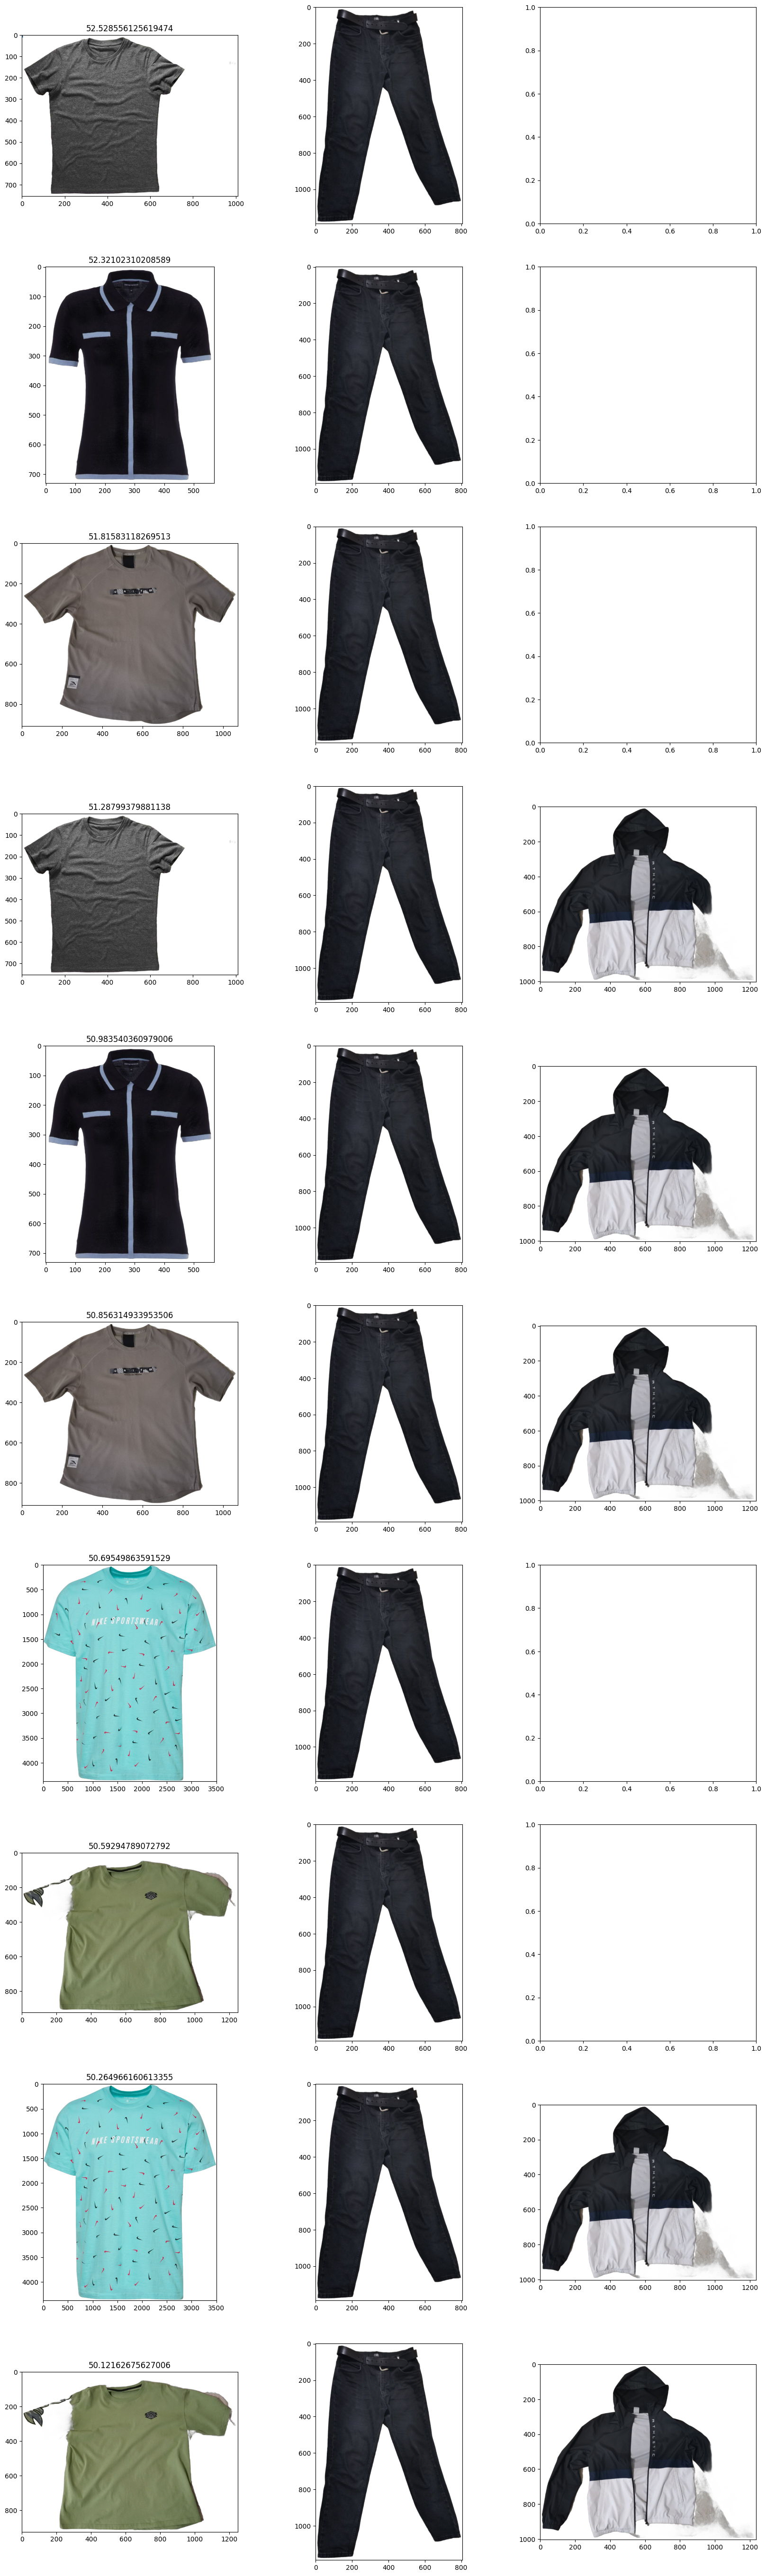

In [113]:
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (20,70)
def plot_outfits(outfits):
    fig, axs = plt.subplots(len(outfits), 3)
    axs[0, 0].plot([1,2,3], [1,4,9])
    for i, outfit in enumerate(outfits):
        axs[i,0].set_title(outfit['score'])
        for j, cloth in enumerate(outfit['clothes']):
            axs[i, j].imshow(cloth['cloth'])
#    axs[1, 1].scatter(x, y)
plot_outfits(outfits)    

In [86]:
(-0.3111113) **(1/2)

(3.4153777817089576e-17+0.5577735203467443j)